In [1]:
import numpy as np
import sys,os
sys.path.append(os.getcwd()[:-11]+'src/')
from models import *
from topological_methods import *
import matplotlib.pyplot as plt
clrs = plt.cm.tab20.colors

In [2]:
#Plots for normal initialization
import math

mean = 0
std = 0.1
n_perms = 100
out_dims = [2,5,10,25,50,100]#,500,1000]
in_dims = [2,5,10,25,50,100]

#eval points
res = 100
lims = 5

    
region_ranks = np.zeros([len(in_dims),len(out_dims),n_perms])
rank_est = np.zeros([len(in_dims),len(out_dims),n_perms])
for m, dim_in in enumerate(in_dims):
    for n, dim_out in enumerate(out_dims):
        for l in range(n_perms):
            x = torch.Tensor(lims*2*(np.random.rand(dim_in, res)-0.5)).T
            rand_model = FeedforwardNetwork(input_size=dim_in,hidden_sizes=[dim_out],mean=mean,std=std, init_type='normal')
            out = rand_model(x)[0]
            out_code = torch.sign(out).unique(dim=0)#[torch.sum(out[i]>0,axis=1) for i in range(len(out))]
            region_ranks[m,n,l] = min(rand_model.compute_rank(out_code))
#            region_ranks[m,n,l] = sum(out_code[0]<dim_in).item()>0

In [3]:
#Plots for scaling with index(R)
n_neurons = 100
inpt_dim = 50
R_indxs = np.arange(1,n_neurons,4)#[0,2,3,5,10,50,100,500]
region_min_code = np.zeros([len(R_indxs),n_perms])
for r, r_indx in enumerate(R_indxs):
    for l in range(n_perms):
        x = torch.Tensor(lims*2*(np.random.rand(inpt_dim, res)-0.5)).T
        rand_model = FeedforwardNetwork(input_size=inpt_dim,hidden_sizes=[n_neurons])
        R = torch.eye(n_neurons)
        rand_inds = np.random.choice(np.arange(0,n_neurons),size=r_indx, replace=False)
        R[rand_inds,rand_inds] = -1
        rand_model.layers[0].weight = torch.nn.Parameter(rand_model.layers[0].weight)
        #with torch.no_grad():
            #rand_model.layers[0].weight[:49] = -rand_model.layers[0].weight[:49]
        rand_model.layers[0].weight = torch.nn.Parameter(R@rand_model.layers[0].weight)
        out = rand_model(x)[0]
        out_code = torch.sign(out).unique(dim=0)#[torch.sum(out[i]>0,axis=1) for i in range(len(out))]
        region_min_code[r,l] = min(rand_model.compute_rank(out_code))#torch.min(out_code[0]).item()
theory_curve = np.concatenate([np.arange(0,int(n_neurons/2)), int(n_neurons/2)-np.arange(0,int(n_neurons/2))])

In [4]:
#Plots for Dale-scaling with index(R)
R_indxs_dale = np.arange(1,inpt_dim,2)#[0,2,3,5,10,50,100,500]
region_min_code_dale = np.zeros([len(R_indxs_dale),n_perms])
region_max_code_dale = np.zeros([len(R_indxs_dale),n_perms])
for r, r_indx in enumerate(R_indxs_dale):
    for l in range(n_perms):
        x = torch.Tensor(lims*2*(np.random.rand(inpt_dim, res))).T
        rand_model = FeedforwardNetwork(input_size=inpt_dim,hidden_sizes=[n_neurons])
        R = torch.eye(inpt_dim)
        rand_inds = np.random.choice(np.arange(0,inpt_dim),size=r_indx, replace=False)
        R[rand_inds,rand_inds] = -4
        rand_model.layers[0].weight = torch.nn.Parameter(rand_model.layers[0].weight)
        rand_model.layers[0].weight = torch.nn.Parameter(rand_model.layers[0].weight@R)
        out = rand_model(x)[0]
        out_code = torch.sign(out).unique(dim=0)#[torch.sum(out[i]>0,axis=1) for i in range(len(out))]
        code_rank = rand_model.compute_rank(out_code)
        region_min_code_dale[r,l] = min(code_rank)#out_code[0]).item()
        region_max_code_dale[r,l] = max(code_rank)
#balanced_mode = np.logical_or(np.logical_and(np.mean(region_min_code_dale,1)!=0,np.mean(region_min_code_dale,1)!=n_neurons),
#                              np.logical_and(np.mean(region_max_code_dale,1)!=0,np.mean(region_max_code_dale,1)!=n_neurons))
region_min_code_dale[region_min_code_dale>inpt_dim] = inpt_dim
region_max_code_dale[region_max_code_dale>inpt_dim] = inpt_dim
balanced_mode = np.logical_and(np.mean(region_min_code_dale,1)<inpt_dim,(np.mean(region_max_code_dale,1)==inpt_dim))

In [5]:
#studying the number of low rank regions as a function of the mean of a distribution and the number of output neurons
means = np.linspace(0,0.2,20)
in_dim = 10

region_ranks_mean = np.zeros([len(out_dims),len(means),n_perms])

for d, dim in enumerate(out_dims):
    for m, mean in enumerate(means):
        for n in range(n_perms):
            x = torch.Tensor(lims*2*(np.random.rand(in_dim, res)-0.5)).T
            rand_model = FeedforwardNetwork(input_size=in_dim,hidden_sizes=[dim],mean=mean,std=std, init_type='normal')
            out = rand_model(x)[0]
            out_code = torch.sign(out).unique(dim=0)#[torch.sum(out[i]>0,axis=1) for i in range(len(out))]
            region_ranks_mean[d,m,n] = min(rand_model.compute_rank(out_code))#sum(out_code[0]<in_dim).item()>0
#min(*[sum(out_code[i]<in_dim).item()>0 for i in range(len(out))])#sum(out_code<in_dim).item()/res#

In [ ]:
depth = 10
in_dim_ = 25
region_ranks_depth = np.zeros([depth,len(out_dims),n_perms])

for m, n_out in enumerate(out_dims):
    print(m)
    for n in range(n_perms):
        ranks_at_points = np.zeros([depth,res])
        x = torch.Tensor(lims*2*(np.random.rand(in_dim_, res)-0.5)).T
        rand_model = FeedforwardNetwork(input_size=in_dim_,hidden_sizes=[n_out for k in range(depth)],mean=1,std=1,init_type='normal')
        for i,x_i in enumerate(x):
            ranks_at_points[:,i] = rand_model.compute_rank_at_point(x_i)
        region_ranks_depth[:,m,n] = np.min(ranks_at_points,1)

0
1
2
3
4


In [ ]:
plt.imshow(ranks_at_points)

In [ ]:
plt.plot(np.mean(region_ranks_depth,2))

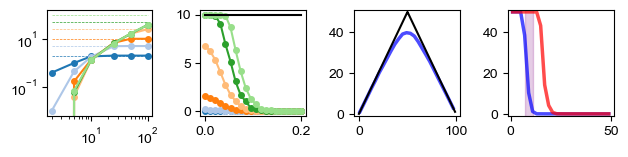

In [45]:
fig_height = 11.7/7
fig_width = 8.3/1.3
clrs = plt.cm.tab20.colors
plt.rcParams["font.family"] = "Arial"

fig, ax = plt.subplots(1,4,figsize=(fig_width,fig_height))#,dpi=300)

for k in range(len(out_dims)):
    ax[0].plot(out_dims, np.mean(region_ranks,2)[k],'-o',color=clrs[k],markersize=4)
    ax[0].plot(out_dims, in_dims[k]*np.ones(len(out_dims)),'--',color=clrs[k],lw=0.5)
    #ax[0].plot([in_dims[k],in_dims[k]], [0,out_dims[k]],'--',color=clrs[k],lw=0.5)
    
#ax[0].set_xlabel('$n_1$')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
#ax[0].set_ylabel('$P[rank(\Phi^1)<m]$')

for k in range(len(out_dims)):
    ax[1].plot(means,np.mean(region_ranks_mean[k],1),'-o',color=clrs[k],markersize=4)
ax[1].plot(means,in_dim*np.ones(len(means)),'k')
#ax[1].set_yscale('log')


ax[2].plot(R_indxs, np.mean(region_min_code,1),'-',color='blue',lw=2.5,alpha=0.7)
#ax[2].errorbar(R_indxs, np.mean(region_min_code,1),yerr=1*np.std(region_min_code,1),color='red', fmt='none',markersize=4)
ax[2].plot(theory_curve,'k')
ax[2].set_ylim(-1,51)
#ax[1].set_xlabel('indx($R$)')
#ax[0,1].set_xscale('log')
#ax[1].set_ylabel('$min(C_{J})$')
#ax[0,1].set_yscale('log')
#ax[0,0].legend(in_dims)

ax[3].plot(R_indxs_dale, np.mean(region_min_code_dale,1),'-',color='blue',lw=2.5,alpha=0.7)
ax[3].plot(R_indxs_dale, np.mean(region_max_code_dale,1),'-',color='red',lw=2.5,alpha=0.7)
#ax[3].fill_between(R_indxs,
#                   np.mean(region_min_code_dale,1)-4*np.std(region_min_code_dale,1),
#                   np.mean(region_min_code_dale,1)+4*np.std(region_min_code_dale,1),
#                   alpha=0.5,color='red',zorder=100)
#ax[3].errorbar(R_indxs, np.mean(region_min_code_dale,1),yerr=1*np.std(region_min_code_dale,1),color='red', fmt='none',markersize=4)
ax[3].fill_betweenx(np.arange(-10,60),R_indxs_dale[balanced_mode][0],R_indxs_dale[balanced_mode][-1],alpha=0.2,color='purple')
ax[3].set_ylim(-1,51)

#ax[2].set_xlabel('$\mu$')
#ax[2].set_ylabel('$P[rank(\Phi^1)<m]$')

#for k in range(len(R_indxs_2)):
#    ax[3].plot(np.arange(1,depth+1), np.mean(region_ranks_depth[:,k],1),'-o',color=clrs[k],markersize=4)
#ax[3].set_xlabel('depth')
fig.tight_layout()
fig.savefig("/Users/kosio/Figures/MfldClassification/top_destr.png",dpi=500, transparent=True)

In [ ]:
plt.plot(R_indxs_dale, np.mean(region_min_code_dale,1),'-',color='blue',lw=2.5,alpha=0.7)
plt.plot(R_indxs_dale, np.mean(region_max_code_dale,1),'-',color='red',lw=2.5,alpha=0.7)
plt.fill_betweenx(np.arange(-10,60),R_indxs_dale[balanced_mode][0],R_indxs_dale[balanced_mode][-1],alpha=0.2,color='purple')
int(inpt_dim/4)

In [ ]:
plt.plot(np.mean(region_ranks,2)[:,-2])
plt.plot(np.mean(region_ranks,2)[:,-1])